In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Бинарная классификация

Задача бинарной классификации - найти правильное разбиение двух классов объктов в пространстве признаков. Рассмотрим простой пример такой классификации.

In [2]:
np.random.seed(42)

## 1.1 Простой пример с линейно разделимыми данными

In [3]:
X_1 = np.random.normal(size=(100,2)) 
y_1 = np.ones(100)
X_2 = np.random.normal(loc=5.0, size=(100,2))
y_2 = np.zeros(100)

X = np.concatenate((X_1, X_2), axis=0) # Полезная функция, которая позволяет состыковать два массива вдоль выбранной оси
y = np.concatenate((y_1, y_2), axis=0)

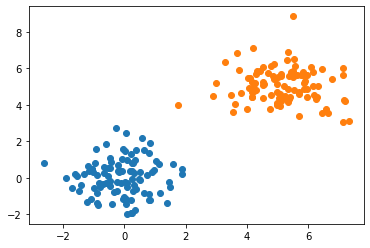

In [4]:
plt.scatter(X_1[:,0], X_1[:,1])
plt.scatter(X_2[:,0], X_2[:,1])
plt.show()

Попробуем воспользоваться знанием о методе опорных векторов и построем гиперплоскость (т.е. линию в 2D), которая разделит нашу выборку в пространтсве признаков

In [5]:
from sklearn.svm import SVC # Импортируем классификатор из модуля svm библиотеки sklearn

In [6]:
model = SVC(kernel='linear') # Пока что выбираем линейное ядро, раз наши признаки линейно разделимы
model.fit(X,y)

SVC(kernel='linear')

Добавим еще несколько точек и посмотрим, как отработает алгортим на них

In [7]:
X_new = np.random.normal(loc=2.0, scale=1.0, size=(5,2))
y_new = model.predict(X_new)

In [8]:
X_new

array([[2.21868309, 1.51562431],
       [3.63885999, 2.22523535],
       [2.16642954, 2.80755563],
       [2.92415238, 2.81285646],
       [0.64927805, 1.36276447]])

In [9]:
y_new

array([1., 0., 0., 0., 1.])

Линейный классификатор использует функцию классификации вида $y = F(x) = sign((w,x) + b)$, где $w$ - вектор нормали к гиперплоскоти, а $b$ - свободный коэффициент. Зная их, можно построить саму гиперплоскость.

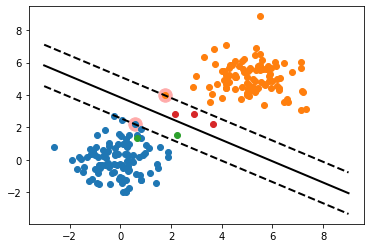

In [11]:
w = model.coef_[0]
b = model.intercept_[0]

x0 = np.linspace(-3.0, 9.0, 1000)
decision_boundary = -w[0]/w[1] * x0 - b/w[1]

margin = 1/w[1] # Расстояние до опорных векторов
gutter_up = decision_boundary + margin
gutter_down = decision_boundary - margin

svs = model.support_vectors_ # Заодно отобразим, какое точки были выбраны в качестве опорных векторов
plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFABAA')
plt.plot(x0, decision_boundary, "k-", linewidth=2)
plt.plot(x0, gutter_up, "k--", linewidth=2)
plt.plot(x0, gutter_down, "k--", linewidth=2)

plt.scatter(X[:,0][y==1], X[:,1][y==1])
plt.scatter(X[:,0][y==0], X[:,1][y==0])
plt.scatter(X_new[:,0][y_new==1], X_new[:,1][y_new==1])
plt.scatter(X_new[:,0][y_new==0], X_new[:,1][y_new==0])
plt.show()

Видно что данные хорошо разделимы и новые точки классифицированы правильно.

## 2.2 А что если они пересекаются?

Посмотрим как отработает алгоритм в этом случае. Создадим второе облачко поближе к первому, указав для него центр нормального распределения в точке (2.0, 2.0)

In [12]:
np.random.seed(12)
X_1 = np.random.normal(size=(100,2)) 
y_1 = np.ones(100)
X_2 = np.random.normal(loc=2.0, size=(100,2)) 
y_2 = np.zeros(100)

X = np.concatenate((X_1, X_2))
y = np.concatenate((y_1, y_2))

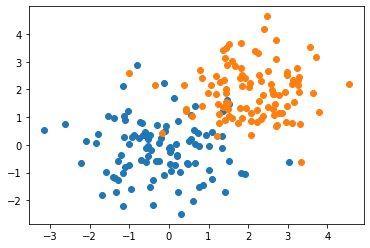

In [13]:
plt.scatter(X[:,0][y==1], X[:,1][y==1])
plt.scatter(X[:,0][y==0], X[:,1][y==0])
plt.show()

Облака явно пересекаются, посмотрим как отработает линейный классификатор...

In [14]:
model = SVC(C=1000, kernel='linear')
model.fit(X,y)

SVC(C=1000, kernel='linear')

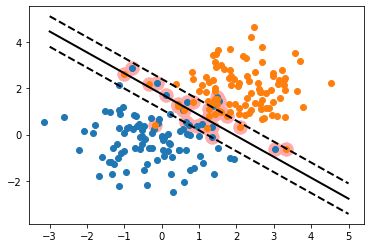

In [15]:
w = model.coef_[0]
b = model.intercept_[0]

x0 = np.linspace(-3.0, 5.0, 1000)
decision_boundary = -w[0]/w[1] * x0 - b/w[1]

margin = 1/w[1]
gutter_up = decision_boundary + margin
gutter_down = decision_boundary - margin

svs = model.support_vectors_
plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFABAA')
plt.plot(x0, decision_boundary, "k-", linewidth=2)
plt.plot(x0, gutter_up, "k--", linewidth=2)
plt.plot(x0, gutter_down, "k--", linewidth=2)

plt.scatter(X[:,0][y==1], X[:,1][y==1])
plt.scatter(X[:,0][y==0], X[:,1][y==0])
plt.show()

Он сделал все, что мог... Отметим, что опорных векторов может быть много, а не только два, как это было в предыдущем примере. Алгоритм сам находит, какие из точек ему удобно использовать. 

## 2.3 Нелинейная классификация

Классифицирующая фунцкция имеет вид $F(x) = sign((w, \phi(x)) + b)$. Строго говоря, классификация все еще линейная, но в пространстве большей размерности, т.е. все элементы выборки вкладываются в некоторое пространство $X$ по закону $\phi: \mathbb{R}^n \rightarrow X$, в котором они линейно разделимы.

Выражение $k(x,x') = (\phi(x), \phi(x'))$ называется ядром классификатора. Обычно используют следующие ядра:
* Полиномиальное : $(\gamma (x,x') + b)^d$
* Радиальная базисная функция (RBF) : $exp(-\gamma ||x - x'||^2)$
* Сигмоид : $tanh((x,x') + c)$

Обучим модель с гауссовым ядром и посморим, как она справится с задачей

In [16]:
model = SVC(kernel='rbf')
model.fit(X,y)

SVC()

Создадим сетку в пространстве признаков и вычилим значение классификатора в каждой точке

In [17]:
x0s = np.linspace(-4.0, 5.0, 100) 
x1s = np.linspace(-4.0, 5.0, 100)
x0, x1 = np.meshgrid(x0s, x1s) # Создает из двух одномерных массивов размера N1 и N2 двумерный массив N1xN2 - нашу сетку
XY = np.c_[x0.ravel(), x1.ravel()] # Немного переформатируем данные для подачи на вход классификатору
y_pred = model.predict(XY).reshape(x0.shape) # Это значния классификатора в каждой точке
y_decision = model.decision_function(XY).reshape(x0.shape) # Это его степень "уверенности" в своем решении

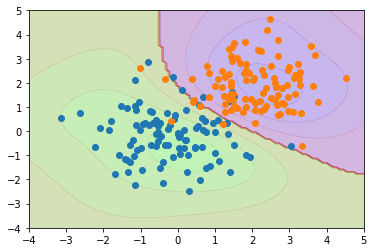

In [18]:
plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2) # Нарисуем контурную карту значений...
plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1) # ...а также линий уровня "уверенности"
plt.scatter(X[:,0][y==1], X[:,1][y==1])
plt.scatter(X[:,0][y==0], X[:,1][y==0])
plt.show()

Видно, что алгоритм с гауссовым ядром справляется чуть лучше. Посмотрим на то, как подбор параметров может помочь в улучшении его работы.

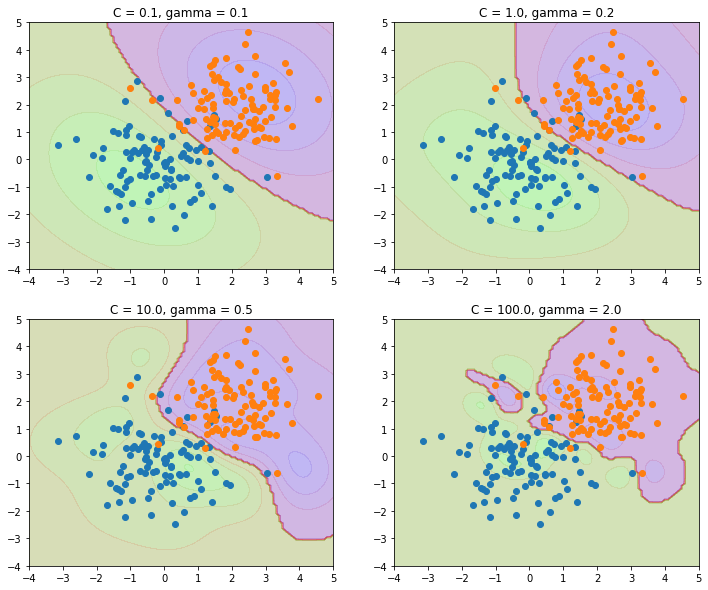

In [19]:
Cs = [0.1, 1.0, 10.0, 100.0]
gammas = [0.1, 0.2, 0.5, 2.0]
i = 0
plt.figure(figsize=(12, 10))
for i, coefs in enumerate(np.array([Cs, gammas]).T):
    C = coefs[0]
    gamma = coefs[1]
    model = SVC(kernel='rbf', C=C, gamma=gamma)
    model.fit(X,y)
    
    x0s = np.linspace(-4.0, 5.0, 100)
    x1s = np.linspace(-4.0, 5.0, 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    XY = np.c_[x0.ravel(), x1.ravel()]
    y_pred = model.predict(XY).reshape(x0.shape)
    y_decision = model.decision_function(XY).reshape(x0.shape)
    
    plt.subplot(221 + i)
    plt.title('C = {}, gamma = {}'.format(C, gamma))
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)
    plt.scatter(X[:,0][y==1], X[:,1][y==1])
    plt.scatter(X[:,0][y==0], X[:,1][y==0])
plt.show()
    

На самом деле этот пример специфичен тем, что пересечение облаков на нем скорее похоже на старый-добрый шум в данных. Поэтому хоть модель стала сложнее, она не справляется сильно лучше, здесь достаточно было бы и линейного классификатора. Но есть и более интересные датасеты...

## 1.3. Задание: Датасет Steels

Итак, твое задание состоит в следующем:
1. Построй регрессор на основе метода опорных векторов. Для этого импортируй класс `sklearn.svm.SVR`
2. Обучи модель для предсказания `0.2% Proof Stress (MPa)` по составу стали и температуре, используя различные ядра: линейное, полиномиальное и гауссовское. Используй `StandardScaler` для скейлинга признаков. Влияет ли его наличие на качество модели? Попробуй объяснить результат. 
3. Найди для каждого из ядер наилучшие параметры: (`C, degree, coef0`) для полиномиального ядра, (`gamma, C`) для гауссовского.
4. Постарайся достигнуть наименьшей ошибки на тестовой выборке. Какая комбинация ядра и параметров дает наименьшую ошибку?

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv('Steels_kaggle.csv')
y = df[' 0.2% Proof Stress (MPa)']
X = df[[' C', ' Si', ' Mn', ' P', ' S', ' Ni', ' Cr', ' Mo', ' Cu', 'V', ' Al', ' N', 'Ceq', 'Nb + Ta', ' Temperature (°C)']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# linear
params = {
    'С': np.arange(),
    'kernel': ['linear']
}
gs_linear = GridSearchCV(SVR(), params, n_jobs=-1, cv=5)
gs_linear.fit(X_train_scaled, y_train)
gs_linear.best_params_

In [22]:
# poly
params = {
    'С': np.arange(),
    'gamma': np.arange(),
    'kernel': ['poly']
}
gs_poly = GridSearchCV(SVR(), params, n_jobs=-1, cv=5)
gs_poly.fit(X_train_scaled, y_train)
gs_poly.best_params_

In [ ]:
# poly
params = {
    'С': np.arange(),
    'degree': np.arange(),
    'coef0': np.arange(),
    'kernel': ['poly']
}
gs = GridSearchCV(SVR(), params, n_jobs=-1, cv=5)
gs.fit(X_train_scaled, y_train)
gs.best_params_